In [1]:
import scanpy as sc
import decoupler as dc

# Only needed for processing
import numpy as np
import pandas as pd

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=300, frameon=False)
sc.set_figure_params(dpi=300)
sc.set_figure_params(figsize=(4, 4))

In [2]:
adata = sc.read_visium('/home/jovyan/brain/kidney/003_UUO_SH045/outs/',
                      count_file='/home/jovyan/brain/kidney/003_UUO_SH045/outs/filtered_feature_bc_matrix.h5',
                      source_image_path='/home/jovyan/brain/kidney/003_UUO_SH045/A1_10x_stitch.tif')
adata.obs['sample'] = list(adata.uns['spatial'].keys())[0]
adata.var_names_make_unique()
adata.var.head()

/opt/conda/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


gene_ids    feature_types genome
Xkr4     ENSMUSG00000051951  Gene Expression   mm10
Gm1992   ENSMUSG00000089699  Gene Expression   mm10
Gm19938  ENSMUSG00000102331  Gene Expression   mm10
Gm37381  ENSMUSG00000102343  Gene Expression   mm10
Rp1      ENSMUSG00000025900  Gene Expression   mm10

In [3]:
adata.obs

in_tissue array_row array_col                      sample
AAACCGGGTAGGTACC-1         1        42        28  Mouse_Kidney_003_UUO_SH045
AAACCGTTCGTCCAGG-1         1        52        42  Mouse_Kidney_003_UUO_SH045
AAACGAGACGGTTGAT-1         1        35        79  Mouse_Kidney_003_UUO_SH045
AAACTGCTGGCTCCAA-1         1        45        67  Mouse_Kidney_003_UUO_SH045
AAAGGGATGTAGCAAG-1         1        24        62  Mouse_Kidney_003_UUO_SH045
...                      ...       ...       ...                         ...
TTGTAATCCGTACTCG-1         1        35        55  Mouse_Kidney_003_UUO_SH045
TTGTCGTTCAGTTACC-1         1        22        58  Mouse_Kidney_003_UUO_SH045
TTGTTCAGTGTGCTAC-1         1        24        64  Mouse_Kidney_003_UUO_SH045
TTGTTGTGTGTCAAGA-1         1        31        77  Mouse_Kidney_003_UUO_SH045
TTGTTTCCATACAACT-1         1        45        27  Mouse_Kidney_003_UUO_SH045

[790 rows x 4 columns]

In [4]:
adata1=sc.read('UUOIH_precast.h5ad')
adata1.obs.index = adata1.obs.index + '-1'
adata1

AnnData object with n_obs × n_vars = 790 × 2000
    obs: 'orig.ident', 'nCount_PRE_CAST', 'nFeature_PRE_CAST', 'batch', 'cluster'

In [5]:
adata.obs['cluster'] = adata1.obs['cluster'][adata.obs_names]
adata.obs

in_tissue array_row array_col                      sample   
AAACCGGGTAGGTACC-1         1        42        28  Mouse_Kidney_003_UUO_SH045  \
AAACCGTTCGTCCAGG-1         1        52        42  Mouse_Kidney_003_UUO_SH045   
AAACGAGACGGTTGAT-1         1        35        79  Mouse_Kidney_003_UUO_SH045   
AAACTGCTGGCTCCAA-1         1        45        67  Mouse_Kidney_003_UUO_SH045   
AAAGGGATGTAGCAAG-1         1        24        62  Mouse_Kidney_003_UUO_SH045   
...                      ...       ...       ...                         ...   
TTGTAATCCGTACTCG-1         1        35        55  Mouse_Kidney_003_UUO_SH045   
TTGTCGTTCAGTTACC-1         1        22        58  Mouse_Kidney_003_UUO_SH045   
TTGTTCAGTGTGCTAC-1         1        24        64  Mouse_Kidney_003_UUO_SH045   
TTGTTGTGTGTCAAGA-1         1        31        77  Mouse_Kidney_003_UUO_SH045   
TTGTTTCCATACAACT-1         1        45        27  Mouse_Kidney_003_UUO_SH045   

                   cluster  
AAACCGGGTAGGTACC-1       7  
AAACCGTTCGTCCAGG-1       7  
AAACGAGACGGTTGAT-1       3  
AAACTGCTGGCTCCAA-1       3  
AAAGGGATGTAGCAAG-1       7  
...                    ...  
TTGTAATCCGTACTCG-1       3  
TTGTCGTTCAGTTACC-1       7  
TTGTTCAGTGTGCTAC-1       7  
TTGTTGTGTGTCAAGA-1       3  
TTGTTTCCATACAACT-1       7  

[790 rows x 5 columns]

In [6]:
adata.obsm['spatial']=adata.obsm['spatial'].astype('float')

In [7]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)

# Annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)



# Normalize the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata)

# Filter higly variable genes
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

# Scale the data
sc.pp.scale(adata, max_value=10)

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


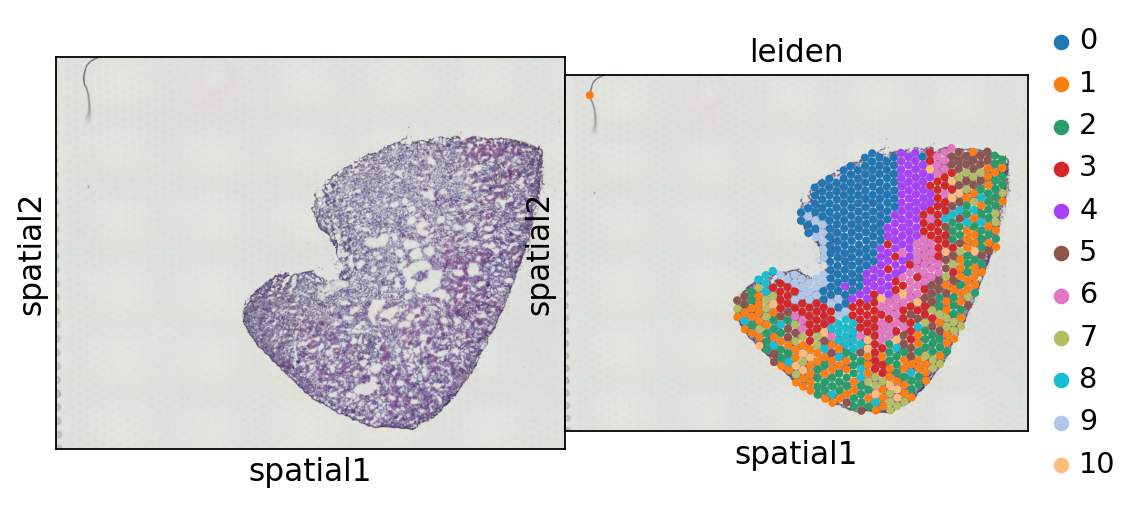

In [8]:
# Generate PCA features
sc.tl.pca(adata, svd_solver='arpack')

# Compute distances in the PCA space, and find spot neighbors
sc.pp.neighbors(adata)

# Run leiden clustering algorithm
sc.tl.leiden(adata)

# Visualize
sc.pl.spatial(adata, color=[None, 'leiden'], size=1.5, wspace=0)

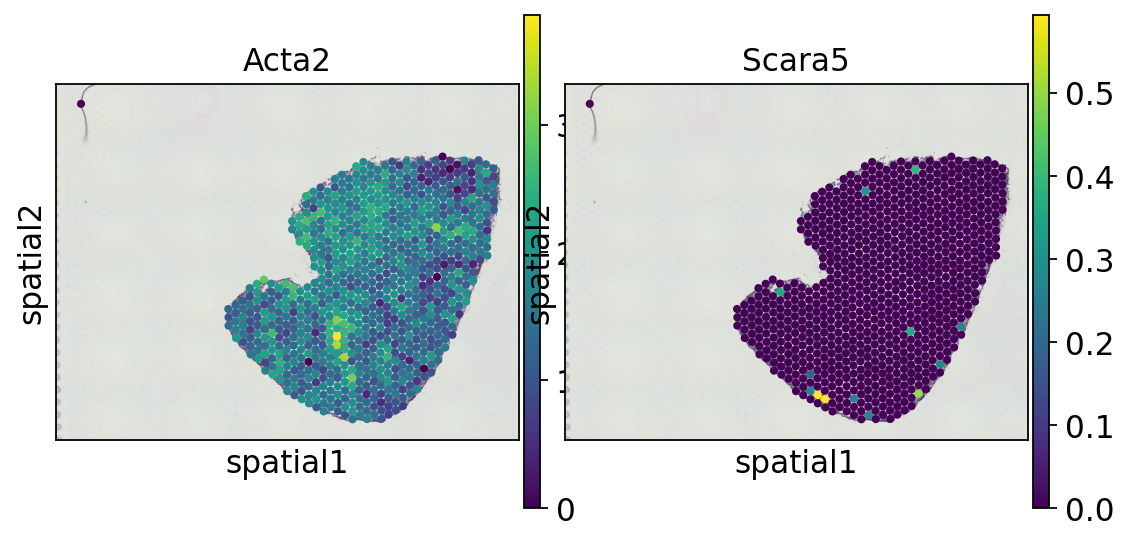

In [36]:
sc.pl.spatial(adata, color=['Acta2', 'Scara5'], size=1.5, wspace=0,save='acta2,scara5.pdf')

In [9]:
net = dc.get_collectri(organism='mouse', split_complexes=False)
net

source  target  weight   
0         Myc    Tert       1  \
1        Spi1   Bglap       1   
2        Spi1  Bglap3       1   
3        Spi1  Bglap2       1   
4       Smad3     Jun       1   
...       ...     ...     ...   
38660   Runx1    Lcp2       1   
38661   Runx1   Prr5l       1   
38662  Twist1    Gli1       1   
38663    Usf1  Nup188       1   
38664  Znf148    Rnls       1   

                                                    PMID  
0      10022128;10491298;10606235;10637317;10723141;1...  
1                                               10022617  
2                                               10022617  
3                                               10022617  
4                                      10022869;12374795  
...                                                  ...  
38660                                           20019798  
38661                                           20019798  
38662                                           11948912  
38663                                           22951020  
38664                                           25295465  

[38665 rows x 4 columns]

In [14]:
net=pd.read_csv('Prnp_target_genes.csv')
net['source']='Prnp'
net['weight']=1
net

target source  weight
0      Abca1   Prnp       1
1        Ace   Prnp       1
2      Acsl3   Prnp       1
3        Ada   Prnp       1
4     Adam10   Prnp       1
..       ...    ...     ...
206  Zcchc24   Prnp       1
207   Zfp217   Prnp       1
208   Zfp422   Prnp       1
209   Zfp462   Prnp       1
210    Zmiz1   Prnp       1

[211 rows x 3 columns]

In [15]:
dc.run_ulm(
    mat=adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

Running ulm on mat with 790 samples and 15258 targets for 1 sources.


100%|██████████| 1/1 [00:00<00:00, 26.23it/s]


In [16]:
adata.obsm['ulm_estimate']

Prnp
AAACCGGGTAGGTACC-1  2.985104
AAACCGTTCGTCCAGG-1  3.035271
AAACGAGACGGTTGAT-1  2.984751
AAACTGCTGGCTCCAA-1  4.196438
AAAGGGATGTAGCAAG-1  2.835557
...                      ...
TTGTAATCCGTACTCG-1  1.700799
TTGTCGTTCAGTTACC-1  2.783036
TTGTTCAGTGTGCTAC-1  1.910498
TTGTTGTGTGTCAAGA-1  3.013797
TTGTTTCCATACAACT-1  3.149787

[790 rows x 1 columns]

In [17]:
adata.obsm['collectri_ulm_estimate'] = adata.obsm['ulm_estimate'].copy()
adata.obsm['collectri_ulm_pvals'] = adata.obsm['ulm_pvals'].copy()
adata

AnnData object with n_obs × n_vars = 790 × 2141
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'cluster', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'leiden_colors'
    obsm: 'spatial', 'X_pca', 'ulm_estimate', 'ulm_pvals', 'collectri_ulm_estimate', 'collectri_ulm_pvals'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [18]:
acts = dc.get_acts(adata, obsm_key='collectri_ulm_estimate')

# We can scale the obtained activities for better visualizations
sc.pp.scale(acts)
acts

AnnData object with n_obs × n_vars = 790 × 1
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'cluster', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'mean', 'std'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'leiden_colors'
    obsm: 'spatial', 'X_pca', 'ulm_estimate', 'ulm_pvals', 'collectri_ulm_estimate', 'collectri_ulm_pvals'

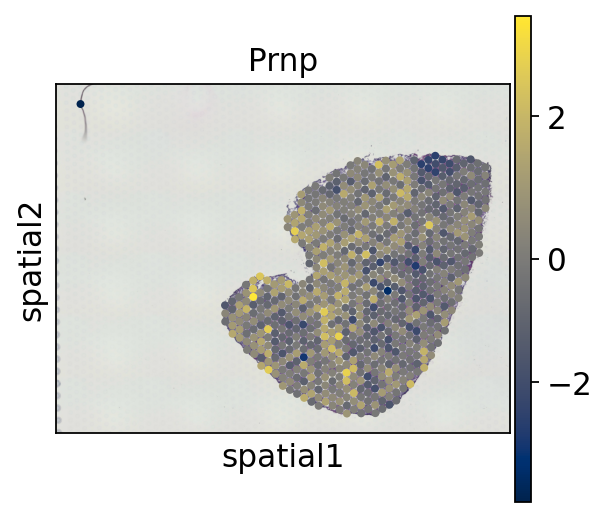

In [34]:
sc.pl.spatial(acts, color=['Prnp'], cmap='cividis', size=1.5, vcenter=0,save='Prnp.pdf')
#sc.pl.violin(acts, keys=['Prnp'], groupby='cluster')

In [22]:
progeny = dc.get_progeny(organism='mouse', top=500)
progeny

source   target     weight       p_value
0     Androgen  Tmprss2  11.490631  0.000000e+00
1     Androgen   Nkx3-1  10.622551  2.242078e-44
2         NFkB   Nkx3-1   2.372983  5.589476e-32
3         TNFa   Nkx3-1   2.871633  1.044050e-27
4     Androgen   Mboat2  10.472733  4.624285e-44
...        ...      ...        ...           ...
6500       p53    Zmym4  -2.325752  1.522388e-06
6501       p53    Cfdp1  -1.628168  1.526045e-06
6502       p53   Vps37d   2.309503  1.537098e-06
6503       p53    Tedc1  -2.274823  1.547037e-06
6504       p53  Ccdc138  -3.205113  1.568160e-06

[6505 rows x 4 columns]

In [23]:
dc.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True
)

# Store in new obsm keys
adata.obsm['progeny_mlm_estimate'] = adata.obsm['mlm_estimate'].copy()
adata.obsm['progeny_mlm_pvals'] = adata.obsm['mlm_pvals'].copy()

Running mlm on mat with 790 samples and 15258 targets for 14 sources.


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


In [24]:
adata.obsm['progeny_mlm_estimate']

Androgen      EGFR  Estrogen   Hypoxia  JAK-STAT   
AAACCGGGTAGGTACC-1  1.168064  2.966024 -0.961174  3.256735 -0.031020  \
AAACCGTTCGTCCAGG-1  2.067549  2.548749 -1.535306  2.493758  0.315898   
AAACGAGACGGTTGAT-1  0.701306  2.424415 -1.754818  4.082564 -0.178337   
AAACTGCTGGCTCCAA-1  1.085171  2.131299 -0.022998  4.263665  0.014199   
AAAGGGATGTAGCAAG-1  1.274503  3.284353 -1.409956  2.909403 -0.004003   
...                      ...       ...       ...       ...       ...   
TTGTAATCCGTACTCG-1  0.926769  2.659953  0.461409  1.265031 -0.553068   
TTGTCGTTCAGTTACC-1  1.569061  3.836308 -0.705955  2.659760 -0.471858   
TTGTTCAGTGTGCTAC-1  2.094786  2.703903 -2.370840  2.070169 -1.353448   
TTGTTGTGTGTCAAGA-1  0.289900  3.159697 -1.261160  4.112834  1.028428   
TTGTTTCCATACAACT-1  1.775808  2.503139 -0.917781  2.934437 -0.002267   

                        MAPK      NFkB      PI3K      TGFb      TNFa   
AAACCGGGTAGGTACC-1 -4.326555 -1.867284 -1.550105  3.468152  2.679999  \
AAACCGTTCGTCCAGG-1 -4.551197 -1.981400 -1.184330  2.263124  2.705744   
AAACGAGACGGTTGAT-1 -3.431228 -2.211877 -0.703587  4.499282  1.788530   
AAACTGCTGGCTCCAA-1 -3.644810 -1.147981  1.204523  9.316445  1.169187   
AAAGGGATGTAGCAAG-1 -2.726918 -2.062273 -1.007924  4.084956  3.083952   
...                      ...       ...       ...       ...       ...   
TTGTAATCCGTACTCG-1 -3.648900 -1.059017 -0.544972  3.316010  1.391524   
TTGTCGTTCAGTTACC-1 -4.083026 -2.250748 -0.941873  2.545596  2.437627   
TTGTTCAGTGTGCTAC-1 -3.180434 -1.482747 -0.894392  3.775308  1.803146   
TTGTTGTGTGTCAAGA-1 -3.190460 -1.673496 -1.145554  3.304666  1.520813   
TTGTTTCCATACAACT-1 -3.807773 -1.663958 -1.529233  4.818491  2.655056   

                       Trail      VEGF       WNT       p53  
AAACCGGGTAGGTACC-1 -3.353810 -0.014394 -2.328633  1.323562  
AAACCGTTCGTCCAGG-1 -4.054083 -0.557630 -1.732445  1.346312  
AAACGAGACGGTTGAT-1 -3.714564 -0.866811 -0.866243  1.819831  
AAACTGCTGGCTCCAA-1 -4.195582 -0.240544 -1.731129  1.741919  
AAAGGGATGTAGCAAG-1 -3.338960 -0.906602 -1.813625  1.061391  
...                      ...       ...       ...       ...  
TTGTAATCCGTACTCG-1 -3.238905 -1.685934 -0.724590  2.804893  
TTGTCGTTCAGTTACC-1 -2.959975 -0.123741 -1.754975  1.865757  
TTGTTCAGTGTGCTAC-1 -2.605916 -0.822707 -2.414425  0.677470  
TTGTTGTGTGTCAAGA-1 -2.851084 -0.095257 -0.661351  1.965435  
TTGTTTCCATACAACT-1 -3.336868 -0.187258 -1.644886  2.365070  

[790 rows x 14 columns]

In [25]:
acts = dc.get_acts(adata, obsm_key='progeny_mlm_estimate')

# We can scale the obtained activities for better visualizations
sc.pp.scale(acts)
acts

AnnData object with n_obs × n_vars = 790 × 14
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'cluster', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'mean', 'std'
    uns: 'spatial', 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'leiden_colors'
    obsm: 'spatial', 'X_pca', 'ulm_estimate', 'ulm_pvals', 'collectri_ulm_estimate', 'collectri_ulm_pvals', 'mlm_estimate', 'mlm_pvals', 'progeny_mlm_estimate', 'progeny_mlm_pvals'

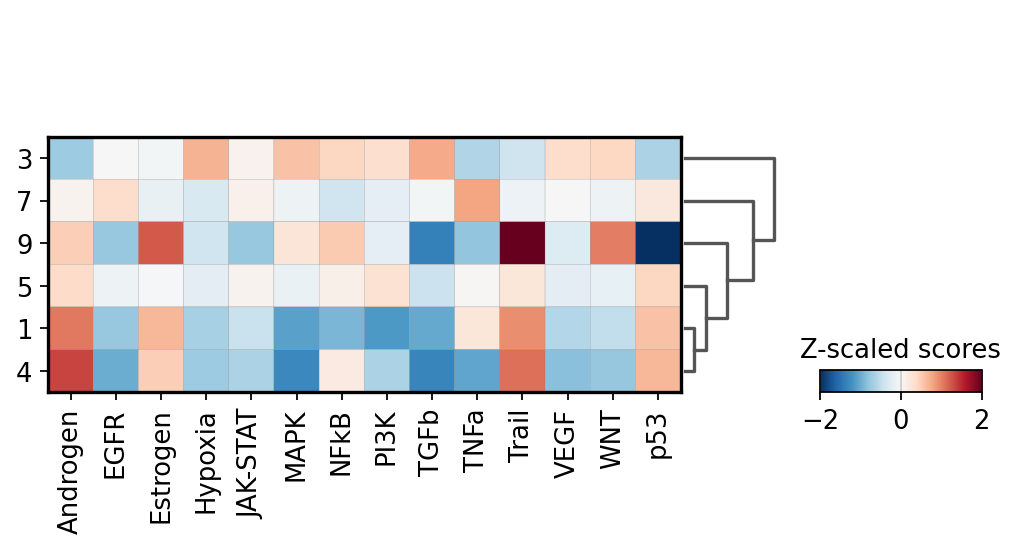

In [27]:
sc.pl.matrixplot(acts, var_names=acts.var_names, groupby='cluster', dendrogram=True,
                 colorbar_title='Z-scaled scores', vmin=-2, vmax=2, cmap='RdBu_r')

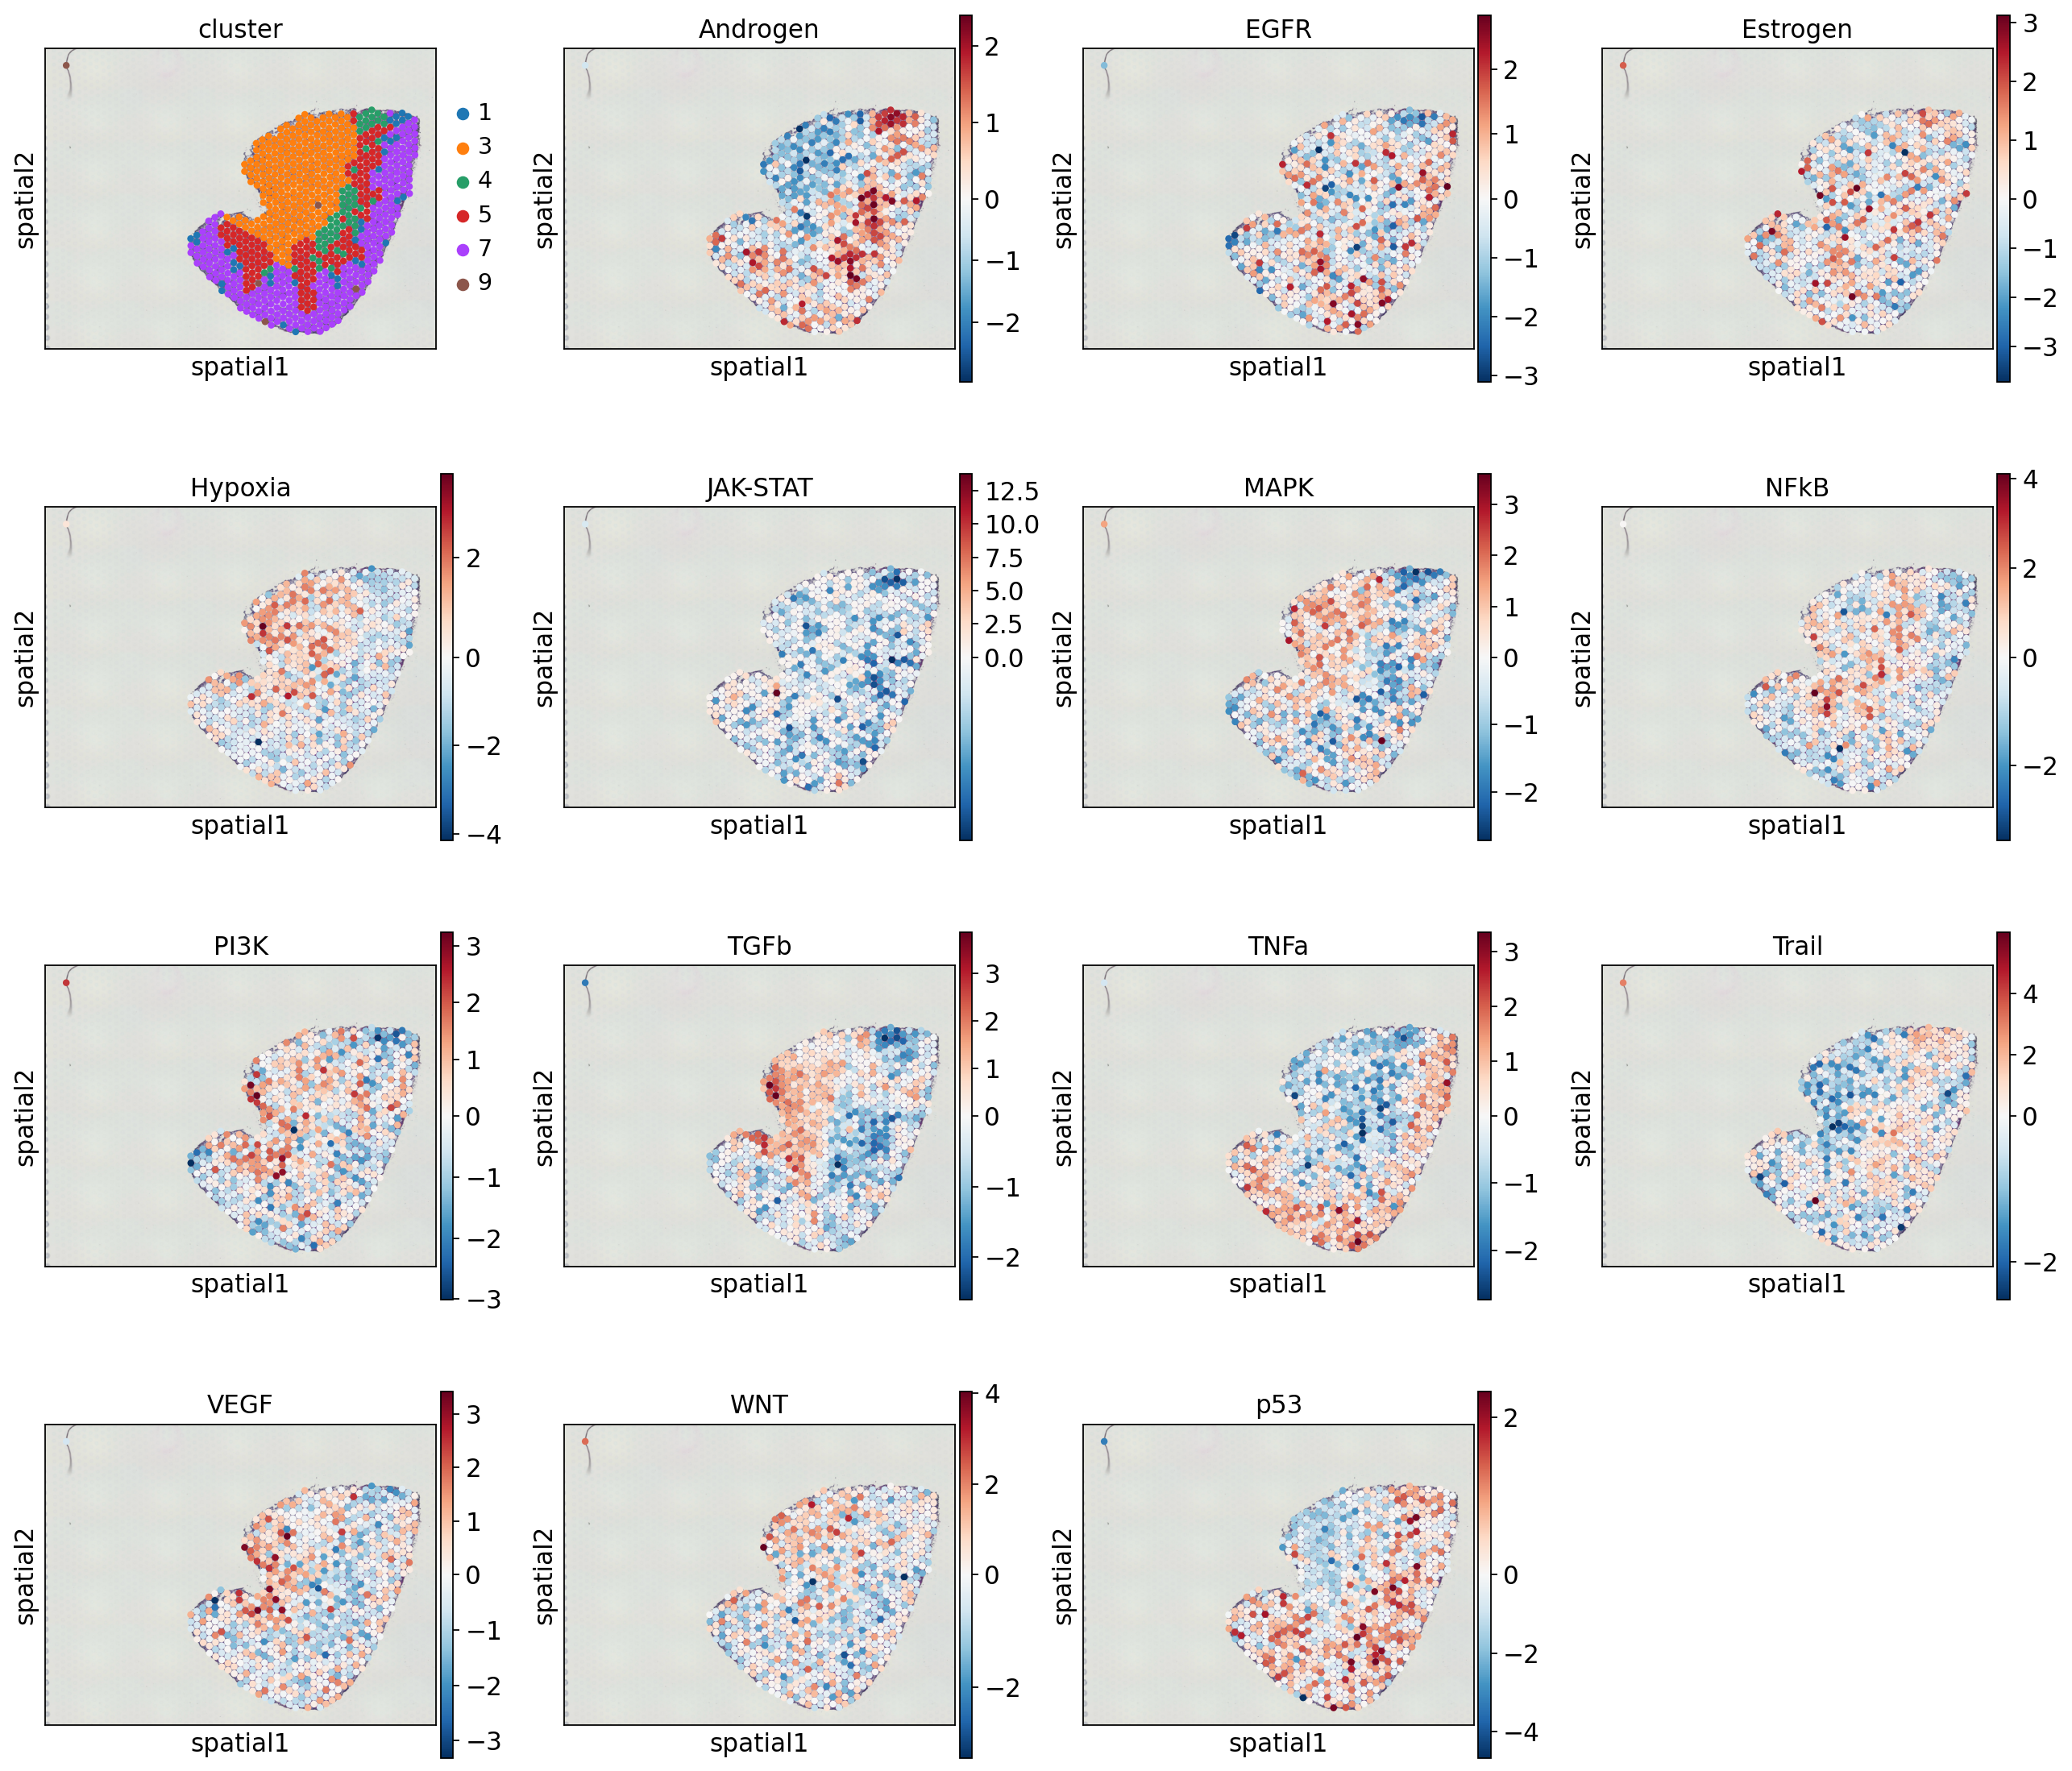

In [28]:
sc.pl.spatial(acts, color=['cluster','Androgen','EGFR','Estrogen','Hypoxia','JAK-STAT','MAPK','NFkB','PI3K','TGFb','TNFa','Trail','VEGF','WNT','p53'], cmap='RdBu_r', size=1.5, vcenter=0,save='pathway_UUOIH.pdf')